# Прикладные задачи анализа данных

## Домашнее задание 4

В этой работе мы будем решать задачу рекомендаций музыки. Для этого мы реализуем метод коллаборативной фильтрации и модель со скрытыми переменными, сравним их между собой и попытаемся сделать выводы. Во всех заданиях разрешается переписывать код по своему усмотрению, предложенные шаблоны несут лишь рекомендательный характер.

In [ ]:
from sklearn.preprocessing import LabelEncoder

import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from typing import Callable, List\

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as scs

In [ ]:
ratings = pd.read_csv('music_dataset.csv')
ratings.head()

,userId,trackId
0,0,14
1,0,95
2,0,219
3,0,220
4,0,404


In [ ]:
tracks_info = pd.read_csv('tracks_info.csv')
tracks_info.head()

,id,name,artists
0,0,What There Is,['a-ha']
1,1,I'll Play The Blues For You,['Albert King']
2,2,Breaking Up Somebody's Home,['Albert King']
3,3,Imma Be,['Black Eyed Peas']
4,4,Boom Boom Pow,['Black Eyed Peas']


Для оценки качества рекомендаций мы будем использовать метрику $MAP@k$.

$$
MAP@k = \frac{1}{N} \sum_{u = 1}^N AP_u@k
$$
$$
AP_u@k = \frac{1}{\min(k, n_u)} \sum_{i=1}^k r_u(i) p_u@i
$$
$$p_u@k = \dfrac{1}{k}\sum_{j=1}^k r_u(j)$$


*   $N$ - количество пользователей.
*   $n_u$ - число релевантных треков пользователя $u$ на тестовом промежутке.
*   $r_u(i)$ - бинарная величина: относится ли трек на позиции $i$ к релевантным.

**Задание 1 (1 балл).** Реализуйте метрику $MAP@k$.

In [ ]:
def mapk(relevant: List[List[int]], predicted: List[List[int]], k: int = 20):
    ap_k, count = 0, 0
    for relevant_items, predicted_items in zip(relevant, predicted):
        if not relevant_items:
            continue
        correct = np.isin(predicted_items[:k], relevant_items)
        ap_k += np.sum(np.cumsum(correct) / np.arange(1, k + 1) * correct) / \
            min(k, len(relevant_items))
        count += 1

    map_k = ap_k / count
    return map_k

In [ ]:
relevant = [
    [1, 7, 6, 2, 8],
    [1, 5, 4, 8],
    [8, 2, 5]
]

pred = [
    [8, 1, 5, 0, 7, 2, 9, 4],
    [0, 1, 8, 5, 3, 4, 7, 9],
    [9, 2, 0, 6, 8, 5, 3, 7]
]

assert round(mapk(relevant, pred, k=5), 4) == 0.4331

Разделим данные на тренировочные и тестовые так, чтобы в теcтовый датасет попали 50 последних треков каждого пользователя.

In [1]:
def train_test_split(ratings):
    train_ratings, test_ratings = [], []
    num_test_samples = 50

    # getting train samples
    for userId, user_data in tqdm(ratings.groupby('userId')):
        train_ratings += [user_data[:-num_test_samples]]

    train_ratings = pd.concat(train_ratings).reset_index(drop=True)
    all_train_items = train_ratings['trackId'].unique()

    # getting train samples
    # we drop all tracks that are not presented it the training samples,
    # because we won't be able to learn representations for them
    for userId, user_data in tqdm(ratings.groupby('userId')):
        test_items = user_data[-num_test_samples:]
        test_items = test_items[np.isin(test_items['trackId'], all_train_items)]
        test_ratings += [test_items]

    test_ratings = pd.concat(test_ratings).reset_index(drop=True)

    return train_ratings, test_ratings

In [2]:
train_ratings, test_ratings = train_test_split(ratings)

NameError: name 'ratings' is not defined

Почистим табличку с информацией о треках и закодируем id треков так, чтобы они соответствовали их порядковому номеру.

In [ ]:
redundant_rows = np.where(~np.isin(tracks_info['id'], train_ratings['trackId'].unique()))[0]
tracks_info.drop(redundant_rows, inplace=True)
tracks_info = tracks_info.reset_index(drop=True)

In [ ]:
def ids_encoder(ratings):
    users = sorted(ratings['userId'].unique())
    items = sorted(ratings['trackId'].unique())

    # create users and items encoders
    uencoder = LabelEncoder()
    iencoder = LabelEncoder()

    # fit users and items ids to the corresponding encoder
    uencoder.fit(users)
    iencoder.fit(items)

    return uencoder, iencoder

In [ ]:
uencoder, iencoder = ids_encoder(train_ratings)
train_ratings['trackId'] = iencoder.transform(train_ratings['trackId'].tolist())
test_ratings['trackId'] = iencoder.transform(test_ratings['trackId'].tolist())
tracks_info['id'] = iencoder.transform(tracks_info['id'].tolist())

In [ ]:
train_ratings.head()

,userId,trackId
0,0,14
1,0,95
2,0,219
3,0,220
4,0,404


In [ ]:
test_ratings.head()

,userId,trackId
0,0,57582
1,0,57802
2,0,57957
3,0,58174
4,0,59168


Соберем все релевантные треки для каждого пользователя в список.

In [ ]:
test_relevant = []
test_users = []
for user_id, user_data in test_ratings.groupby('userId'):
    test_relevant += [user_data['trackId'].tolist()]
    test_users.append(user_id)

**Задание 2 (1 балл).** Реализуйте метод `get_test_recommendations` в классе `BaseModel`. Он принимает на вход параметр `k` и возвращает массив из `k` наиболее подходящих треков для каждого пользователя. Не забывайте удалять уже прослушанные треки из рекомендуемых.

In [ ]:
class BaseModel:
    def __init__(self, ratings: pd.DataFrame):
        self.ratings = ratings
        self.n_users = len(np.unique(self.ratings['userId']))
        self.n_items = len(np.unique(self.ratings['trackId']))

        self.R = np.zeros((self.n_users, self.n_items))
        self.R[self.ratings['userId'], self.ratings['trackId']] = 1.

    def recommend(self, uid: int):
        """
        param uid: int - user's id
        return: [n_items] - vector of recommended items sorted by their scores in descending order
        """
        raise NotImplementedError

    def remove_train_items(self, preds: List[List[int]], k: int):
        """
        param preds: [n_users, n_items] - recommended items for each user
        param k: int
        return: np.array [n_users, k] - recommended items without training examples
        """
        new_preds = np.zeros((len(preds), k), dtype=int)
        for user_id, user_data in self.ratings.groupby('userId'):
            user_preds = preds[user_id]
            new_preds[user_id] = user_preds[~np.in1d(user_preds, user_data['trackId'])][:k]

        return new_preds

    def get_test_recommendations(self, k):
        test_preds = []

        # your code here: (￣▽￣)/♫•*¨*•.¸¸♪
        for user in tqdm(sorted(np.unique(self.ratings['userId']))):
          test_preds.append(self.recommend(user))

        return self.remove_train_items(test_preds, k)

## Часть 1. Коллаборативная фильтрация (User2User)

Идея: чтобы выбрать треки, которые понравятся пользователю, можно набрать несколько похожих на него пользователей (соседей) и посмотреть, какие треки они слушают. После этого остается агрегировать треки этих пользователей и выбрать самые популярные. Соответственно, задача состоит из двух частей: выбора функции похожести двух пользователей и способа агрегации.

В качестве функции похожести мы будем использовать две метрики:

1. Корреляция Пирсона $$s(u, v) = \frac{\sum_{i \in I_u \cap I_v} r_{ui}r_{vi}}{\sqrt{\sum_{i \in I_u} r_{ui} ^2}\sqrt{\sum_{i \in I_v} r_{vi}^2}} $$

2. Мера Жаккара

$$ s(u, v) = \frac{|I_u \cap I_v|}{|I_u \cup I_v|} $$


Корреляция Пирсона немного видоизменена, чтобы подходить под нашу задачу.


Во всех формулах
* $I_u$ - множество треков, прослушанных пользователем $u$.
* $r_{ui}$ - прослушал ли пользователь $u$ трек $i$ (0 или 1).

Множество соседей определим как $$N(u) = \{ v \in U \setminus \{u\} \mid s(u, v) > \alpha\},$$ где $\alpha \, - $ гиперпараметр.



Для агрегации мы будем пользоваться следующей формулой.
$$
\hat{r}_{ui} = \frac{\sum_{v \in N(u)} s(u, v) r_{vi}}{\sum_{v \in N(u)} |s(u, v)|}
$$

**Задание 3.1 (1 балл).** Реализуйте функцию подсчета корреляции Пирсона.

**Задание 3.2 (1 балл).** Реализуйте функцию подсчета меры Жаккара.

Функции принимают матрицу оценок и вектор оценок пользователя $u$ и возвращают вектор со значениями похожести пользователя $u$ на всех пользователей. Старайтесь писать оптимизированный код, за неэффективную реализацию оценка может быть снижена.

In [ ]:
def pearson(ratings: np.array, user_vector: np.array) -> np.array:
    # your code here: (￣▽￣)/♫•*¨*•.¸¸♪
    num = np.sum(np.logical_and(ratings, user_vector), axis = 1)
    denom = np.sqrt(np.sum(ratings)) * np.sqrt(np.sum(user_vector))
    return num / denom


def jaccard(ratings: np.array, user_vector: np.array) -> np.array:
    # your code here: (￣▽￣)/♫•*¨*•.¸¸♪
    intersect = np.sum(ratings * user_vector == 1, axis=1)
    union = intersect + np.sum(ratings != user_vector, axis=1)
    return intersect / union

**Задание 4 (1 балл).** Реализуйте методы `similarity` и `recommend` класса `User2User`. `recommend` возвращает индексы треков, отсортированные в порядке убывания предсказанных оценок.


In [ ]:
class User2User(BaseModel):
    def __init__(self, ratings, similarity_func):
        super().__init__(ratings)

        assert similarity_func in [pearson, jaccard]

        self.similarity_func = similarity_func
        self.alpha = 0.02

    def similarity(self, user_vector: np.array):
        """
        user_vector: [n_items]
        """
        # your code here: (￣▽￣)/♫•*¨*•.¸¸♪
        sim_all = self.similarity_func(self.R, user_vector)
        sim_idx = np.argsort(-sim_all)[1:]

        return sim_all, sim_idx

    def recommend(self, uid: int):
        # your code here: (￣▽￣)/♫•*¨*•.¸¸♪
        user_vector = self.R[uid, :]
        sim_vec, sim_idx = self.similarity(user_vector)
        mask = sim_vec[sim_idx] > self.alpha
        neighbours = sim_idx[mask]
        sims = sim_vec[neighbours]
        num = np.sum(self.R[neighbours, :].T * sims, axis=1)
        denom = np.sum(sims)
        if denom == 0.0:
            r_hat = np.sum(self.R, axis=0)
        else:
            r_hat = num / denom
        best_items_idx = np.argsort(-r_hat)

        return best_items_idx

**Задание 5 (1 балл).** Постройте графики зависимости значений $MAP@k$ от разных $k$ для обоих функций похожести, сравните их между собой, а также с предсказаниями случайного алгоритма и сделайте выводы.

In [ ]:
# your code here: (￣▽￣)/♫•*¨*•.¸¸♪
num_users, num_tracks = ratings['userId'].unique().shape[0], ratings['trackId'].unique().shape[0]
k_s = np.arange(1, 51)

In [ ]:
def remove_train_items(preds, k):
    new_preds = np.zeros((preds.shape[0], k), dtype=int)
    for user_id, user_data in train_ratings.groupby('userId'):
        user_preds = preds[user_id]
        new_preds[user_id] = user_preds[~np.in1d(user_preds, user_data.trackId)][:k]
    return new_preds


def random_prediction(k=10):
    preds = np.tile(np.arange(num_tracks), (num_users, 1))
    for i in tqdm(range(num_users)):
        rand_perm = np.random.permutation(num_tracks)
        preds[i] = preds[i][rand_perm]
    preds = remove_train_items(preds, k)
    return preds

In [ ]:
model_pears = User2User(train_ratings, similarity_func=pearson)
model_jacc = User2User(train_ratings, similarity_func=jaccard)

In [ ]:
test_predicted_u2u_pears = model_pears.get_test_recommendations(k_s[-1])
test_predicted_u2u_jacc = model_jacc.get_test_recommendations(k_s[-1])
random_preds = random_prediction(k=k_s[-1])

u2u_mapk_pears = [mapk(test_relevant, test_predicted_u2u_pears, k=k) for k in tqdm(k_s)]
u2u_mapk_jacc = [mapk(test_relevant, test_predicted_u2u_jacc, k=k) for k in tqdm(k_s)]
random_mapk = [mapk(test_relevant, random_preds, k=k) for k in tqdm(k_s)]

  0%|          | 0/241 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

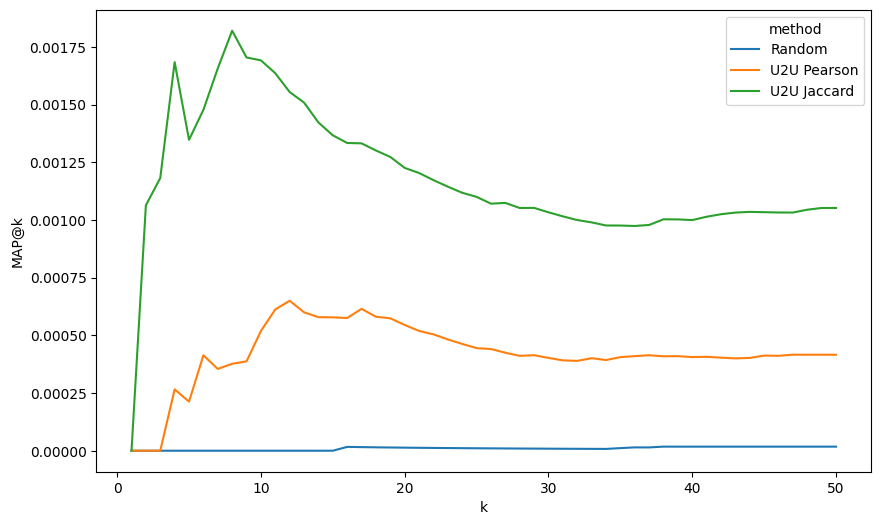

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(k_s, random_mapk, label='Random')
plt.plot(k_s, u2u_mapk_pears, label='U2U Pearson')
plt.plot(k_s, u2u_mapk_jacc, label='U2U Jaccard')
plt.legend(title='method')
plt.xlabel('k')
plt.ylabel('MAP@k')
plt.show()

U2U Jaccard: Этот метод показывает наивысшие значения MAP@k по сравнению с остальными методами на всем диапазоне k. Это говорит о том, что метрика схожести по Jaccard эффективнее других методов для данной задачи. Ну, а хуже всего работает рандом, что логично, так как рекомендации основаны на случайных значениях и не учитывают никакие зависимости.

**Задание 6 (1.5 балла).** Как вы могли заметить, матрица оценок получается очень разреженной, но мы работаем с ней как с обычной, это не дело. Перепишите код так, чтобы все методы могли работать с разреженными матрицами и сравните скорость работы такого подхода с оригинальным.

In [ ]:
# your code here: ‿︵‿︵ヽ(°□° )ノ︵‿︵‿
def pearson_sparse(ratings, user_vector) -> np.array:
    num = np.matrix((ratings.multiply(user_vector)).sum(axis=1)).A1
    ratings_norm = np.sqrt(np.matrix(ratings.multiply(ratings).sum(axis=1)).A1)
    user_vector_norm = np.sqrt(user_vector.multiply(user_vector).sum())
    denom = ratings_norm * user_vector_norm
    denom[denom == 0] = 1e-9
    return num / denom

def jaccard_sparse(ratings, user_vector) -> scs.csr_array:
    intersection = np.sum(ratings * user_vector == 1, axis=1)
    union = intersection + np.sum(ratings != user_vector.toarray(), axis=1)
    return intersection / union

In [ ]:
class User2UserSparse(BaseModel):
    def __init__(self, ratings, similarity_func, alpha=0.02):
        self.ratings = ratings
        self.n_users = len(np.unique(self.ratings['userId']))
        self.n_items = len(np.unique(self.ratings['trackId']))
        self.user_ids, self.item_ids = self.ratings.userId, self.ratings.trackId

        self.R = scs.coo_array(
            (np.ones(self.user_ids.shape),
            (self.user_ids, self.item_ids)),
            shape=(self.n_users, self.n_items)
            ).tocsr()

        self.similarity_func = similarity_func
        self.alpha = alpha

    def similarity(self, user_vector: scs.csr_array):
        """
        user_vector: [n_items]
        """
        sim_all = self.similarity_func(self.R, user_vector)
        sim_idx = np.argsort(-sim_all)[1:]

        return sim_all, sim_idx

    def recommend(self, uid: int):
        user_vector = self.R[[uid], :]
        sim_vec, sim_idx = self.similarity(user_vector)
        mask = sim_vec[sim_idx] > self.alpha
        neighbours = sim_idx[mask]
        similarities = sim_vec[neighbours]
        num = np.sum(self.R[neighbours, :].T * similarities, axis=1)
        denom = np.sum(similarities)
        if denom == 0.0:
            r_hat = np.sum(self.R, axis=0)
        else:
            r_hat = num / denom
        best_items_idx = np.argsort(-r_hat)

        return best_items_idx

In [ ]:
model_pears = User2UserSparse(train_ratings, similarity_func=pearson_sparse)
model_jacc = User2UserSparse(train_ratings, similarity_func=jaccard_sparse)

In [ ]:
model_pears = User2UserSparse(train_ratings, similarity_func=pearson_sparse)
model_jacc = User2UserSparse(train_ratings, similarity_func=jaccard_sparse)

test_predicted_u2u_pears = model_pears.get_test_recommendations(k_s[-1])
test_predicted_u2u_jacc = model_jacc.get_test_recommendations(k_s[-1])

u2u_mapk_pears = [mapk(test_relevant, test_predicted_u2u_pears, k=k) for k in tqdm(k_s)]
u2u_mapk_jacc = [mapk(test_relevant, test_predicted_u2u_jacc, k=k) for k in tqdm(k_s)]

  0%|          | 0/241 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

По tqdm видно, что спарс-подход работает в разы шустрее для пирсона.

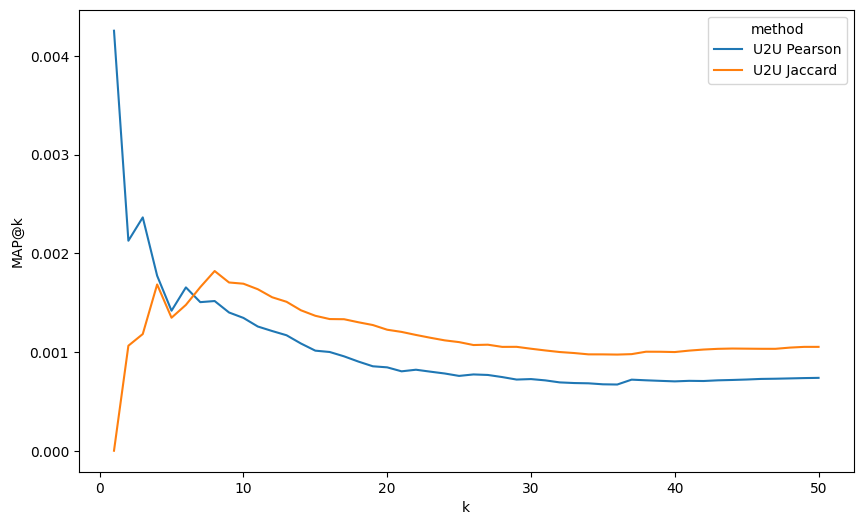

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(k_s, u2u_mapk_pears, label='U2U Pearson')
plt.plot(k_s, u2u_mapk_jacc, label='U2U Jaccard')
plt.legend(title='method')
plt.xlabel('k')
plt.ylabel('MAP@k')
plt.show()

Мы можем посмотреть глазами, насколько хорошо модель рекомендует треки. Для этого сравним уже прослушанные треки с рекомендованными и релевантными для случайного пользователя. Хорошо ли у вас получилось?

На примере 1 из моделей:

In [ ]:
model = User2UserSparse(train_ratings, similarity_func=jaccard_sparse)
user_id = np.random.randint(0, model.n_users)

In [ ]:
listened_tracks = train_ratings[train_ratings.userId == user_id].trackId[:15]

print('Already listened tracks:')

tracks_info.loc[listened_tracks][['name', 'artists']]

Already listened tracks:


,name,artists
215,Lick It Up,['Kiss']
220,I Was Made For Lovin' You,['Kiss']
411,Don't Cry,"[""Guns N' Roses""]"
445,Fire Water Burn,['Bloodhound Gang']
446,Kiss Me Where It Smells Funny,['Bloodhound Gang']
458,The Rock Show,['blink-182']
461,Online Songs,['blink-182']
462,First Date,['blink-182']
463,Every Time I Look For You,['blink-182']
467,Joker & the Thief,['Wolfmother']


In [ ]:
preds = model.get_test_recommendations(15)

print('Predicted tracks:')

tracks_info.loc[preds[user_id]][['name', 'artists']]

  0%|          | 0/241 [00:00<?, ?it/s]

Predicted tracks:


,name,artists
7934,Думай,['F.P.G.']
13075,Дождь,['Блондинка КсЮ']
8394,Broken Promises,['Element Eighty']
2345,Basket Case,['Green Day']
21463,Bodies,['Drowning Pool']
16403,Warriors of the World United,['Manowar']
859,The Memory Remains,"['Metallica', 'Marianne Faithfull']"
3217,Rock & Roll Queen,['The Subways']
7533,Highway to Hell,['AC/DC']
1169,Whiskey in the Jar,['Metallica']


In [ ]:
test_tracks = test_ratings[test_ratings.userId == user_id].trackId[:15]

print('Test-time tracks:')

tracks_info.loc[test_tracks][['name', 'artists']]

Test-time tracks:


,name,artists
67101,Dad Vibes,['Limp Bizkit']


### Часть 2. Модель со скрытыми переменными

В этой части мы пощупаем метод рекомендаций со скрытыми переменными.
Идея: будем предсказывать оценки по формуле
$$
\hat{r}_{ui} = \langle p_u, q_u \rangle,
$$
$p_u \in \mathbb{R}^d$ и $q_i \in \mathbb{R}^d$ - латентные векторы пользователя $u$ и объекта $i$ соответственно.

Оптимизировать мы будем MSE между истинной оценкой пользователя и предсказанной с регуляризацией
$$
L = \sum_{(u, i) \in R} (\hat{r}_{ui} - r_{ui})^2 + \lambda \left(\sum_{u \in U} \|p_u\|^2 + \sum_{i \in I} \|q_i\|^2\right)
$$

**Задание 7 (1.5 балла).** На лекции рассматривались два подхода к оптимизации параметров. Можно это делать обычным стохастческим градинтным спуском, а можно по очереди обновлять матрицы $P, Q$, и тогда получится метод Alternating Least Squares (ALS). Выведите формулы обновления параметров для обоих методов.

**LFM:**

 Мы будем пытаться построить для каждого пользователя $u$ и товара $i$ векторы $p_u$ $∈$ $R^d$ и $q_i$ $∈$ $R^d$, которые
 будут характеризовать «категории интересов». По сути, векторы пользователей и товаров являются представлениями (embeddings), позволяющими свести эти сущности в одно векторное пространство. Скалярным произведением будем оценивать смещение рейтинга относительно среднего рейтинга товара и
 средних оценок выставляемых пользователем.

$$
r_{ui} \approx \langle p_u, q_i \rangle + \bar{r_i} + \bar{r_u}
$$

Мы можем записать функционал ошибки, исходя из способа вычисления сходства:

$$
\sum_{(u, i) \in \mathcal{R}} \left( r_{ui} - \bar{r_u} - \bar{r_i} - \langle p_u, q_i \rangle \right)^2 \rightarrow \min_{P, Q}
$$

Множество пользователей $U$, множество объектов $I$, разреженная матрица $R \in \mathbb{R}^{|U| \times |I|}$, где $r_{ui}$ – некоторая реакция пользователя на товар: оценка, прослушивание трека до конца, клик, лайк/дизлайк.

Если $R'$ – матрица $R$ с центрированными строками и столбцами, то данная задача сводится к низкоранговому матричному разложению:

$$
\| R' - P^T Q \|^2 \rightarrow \min_{P, Q}
$$

Здесь представления пользователей и товаров записаны в столбцах матриц $P$ и $Q$. Существуют модификации, в которых к скалярным произведениям добавляется масштабирующий множитель $\alpha \in \mathbb{R}$:

$$
\| R' - \alpha P^T Q \|^2 \rightarrow \min_{P, Q, \alpha}
$$

Данный функционал можно регуляризовать:

$$
\sum_{(u, i) \in \mathcal{R}} \left( r_{ui} - \bar{r_u} - \bar{r_i} - \langle p_u, q_i \rangle \right)^2 + \lambda \sum_{u \in U} \| p_u \|^2 + \mu \sum_{i \in I} \| q_i \|^2 \rightarrow \min_{P, Q}
$$

Описанная модель и носит название Latent Factor Model (LFM).

\\
**SGD:**

Если на каждом шаге оптимизации мы сэмплируем существующую пару $(u, i)$, веса будут обновляться так, как приведено ниже.

Продифференцируем по $p_u$:
$$
\nabla_{p_u} \bigg[ (\langle p_u, q_i \rangle - r_{ui})^2 + \lambda \left( \|p_u\|^2 + \|q_i\|^2\right) \bigg] = (\langle p_u, q_i \rangle - r_{ui})q_i + 2\lambda p_u.
$$

Тогда обновляем вектор $p_u$ по формуле:
$$
p_u := p_u - 2\eta (\langle p_u, q_i \rangle - r_{ui})q_i - 2\lambda p_u.
$$


Аналогично для $q_i$:
$$
q_i := q_i - 2\eta (\langle p_u, q_i \rangle - r_{ui})p_u - 2\lambda q_i.
$$

\\

**ALS:**

Попеременно фиксируем матрицы $P$ и $Q$ и находим оптимальное решение для каждого столбца матрицы. В начале возьмем градиент по $p_u$ и приравняем к $0$:

$$
\nabla_{p_u} \bigg[ \sum_{u,i} (\langle p_u, q_i \rangle - r_{ui})^2 + \lambda \left(\sum_{u \in U} \|p_u\|^2 + \sum_{i \in I} \|q_i\|^2\right) \bigg] =
$$
$$
= \sum_{i} 2(\langle p_u, q_i \rangle - r_{ui})q_i + 2\lambda p_u = 0.
$$

Воспользовавшись тем, что $a^Tbc = cb^Ta$, получим:
$$
	\sum_{i} r_{ui}q_i - \sum_i q_i q_i^T p_u + \lambda p_u = 0.
$$

Решим относительно $p_u$:

$$
\left(\sum_i q_i q_i^T + \lambda\bar{e} \right) p_u = \sum_i r_{ui} q_i.
$$

Таким образом:

$$
p_u = \left(\sum_i q_i q_i^T + \lambda\bar{e} \right)^{-1} \sum_i r_{ui} q_i.
$$

Решим относительно $q_i$:

$$
\left(\sum_u p_u p_u^T + \lambda\bar{e} \right) q_i = \sum_u r_{ui} p_u.
$$

Таким образом:

$$
q_i = \left(\sum_u p_u p_u^T + \lambda\bar{e} \right)^{-1} \sum_u r_{ui} p_u.
$$


**Задание 8 (2 балла).** Реализуйте методы оптимизации параметров для обоих алгоритмов.

In [ ]:
class HiddenVars(BaseModel):
    def __init__(self, ratings, dim=128, mode='sgd'):
        super().__init__(ratings)

        np.random.seed(0)
        self.dim = dim
        self.user_ids, self.item_ids = ratings.userId, ratings.trackId
        assert mode in ['sgd', 'als']
        self.mode = mode

        self.P = np.random.normal(size=(self.n_users, dim))
        self.Q = np.random.normal(size=(self.n_items, dim))
        #self.R = np.zeros((self.n_users, self.n_items))
        self.lr = 0.01
        self.lamb = 0.01

    def fit(self, num_iters=5):

        np.random.seed(0)
        for epoch in tqdm(range(num_iters)):
            if self.mode == 'sgd':
                u = np.random.randint(0, self.n_users)
                i = np.random.choice(np.where(self.R[u] == 1)[0])

                assert self.R[u, i] == 1.0

                self.P[u] = self.P[u] - self.lr * 2 * (self.P[u] @ self.Q[i] - self.R[u, i]) * self.Q[i] - self.lamb * 2 * self.P[u]
                self.Q[i] = self.Q[i] - self.lr * 2 * (self.P[u] @ self.Q[i] - self.R[u, i]) * self.P[u] - self.lamb * 2 * self.Q[i]

            elif self.mode == 'als':
                self.P = (np.linalg.inv(self.Q.T @ self.Q + self.lamb * np.eye(self.dim)) @ self.Q.T @ self.R.T).T
                self.Q = (np.linalg.inv(self.P.T @ self.P + self.lamb * np.eye(self.dim)) @ self.P.T @ self.R).T

                #RQ = self.R @ self.Q
                #E = np.eye(self.dim)
                #for u in tqdm(range(self.n_users)):
                #   relevant_items = self.item_ids[self.user_ids == u]
                #   Q_rel = self.Q[relevant_items]
                #   QQ = np.einsum("ij, ik -> jk", Q_rel, Q_rel)
                #   self.P[u] = np.linalg.inv(QQ + 1e-7 * E) @ RQ[u]

                #RP = self.R.T @ self.P
                #for i in tqdm(range(self.n_items)):
                #   relevant_users = self.user_ids[self.item_ids == i]
                #   P_rel = self.P[relevant_users]
                #   PP = np.einsum("ij, ik -> jk", P_rel, P_rel)
                #   self.Q[i] = np.linalg.inv(PP + 1e-7 * E) @ RP[i]


    def recommend(self, uid):
        pred_rating = self.P[uid] @ self.Q.T

        return np.argsort(pred_rating)[::-1]

**Задание 9 (1 балл).** Для обоих алгоритмов подберите оптимальные значения размерности скрытого пространства $d$ и размера предсказания $k$. Как изменяется качество предсказаний с числом итераций обучения? Постройте соответствующие графики, сравните со случайным подхом и User2User, сделайте выводы. Какой алгоритм вам кажется более подходящим для данной задачи и почему?

P.S. Хотя бы один из методов обучения должен приводить к лучшим результатам в сравнении с User2User подходом.

P.P.S. Методу LFM свойственно переобучаться, поэтому при подборе параметров полезно смотреть на значения ошибки и оптимизируемой метрики на тренировочном датасете. Вы также можете менять начальную инициализацию и прочие параметры, за исключением архитектуры, на ваш вкус.

In [ ]:
!pip install -q optuna

In [ ]:
import optuna

Для SGD

In [ ]:
# your code here: (￣▽￣)/♫•*¨*•.¸¸♪
def objective(trial):

    dim_params = {
        'dim': trial.suggest_int('dim', 32, 256)
    }

    k_params = {
        'k': trial.suggest_int('k', 3, 20)
    }

    model = HiddenVars(train_ratings, **dim_params)

    model.fit(10000)

    preds = []
    for i in test_users:
        preds.append(model.recommend(i))

    error = mapk(test_relevant, preds, **k_params)

    return error

In [ ]:
study = optuna.create_study(directions = ['maximize'])
study.optimize(objective, n_trials=100)

[I 2024-06-16 19:10:33,565] A new study created in memory with name: no-name-2af638c3-3e08-487f-bc1e-d09a565777ab


  0%|          | 0/10000 [00:00<?, ?it/s]

<ipython-input-32-1d400eaaf929>:27: RuntimeWarning: overflow encountered in multiply
  self.P[u] = self.P[u] - self.lr * 2 * (self.P[u] @ self.Q[i] - self.R[u, i]) * self.Q[i] - self.lamb * 2 * self.P[u]
<ipython-input-32-1d400eaaf929>:27: RuntimeWarning: invalid value encountered in matmul
  self.P[u] = self.P[u] - self.lr * 2 * (self.P[u] @ self.Q[i] - self.R[u, i]) * self.Q[i] - self.lamb * 2 * self.P[u]
<ipython-input-32-1d400eaaf929>:51: RuntimeWarning: invalid value encountered in matmul
  pred_rating = self.P[uid] @ self.Q.T
[I 2024-06-16 19:10:47,364] Trial 0 finished with value: 8.684324793747285e-05 and parameters: {'dim': 128, 'k': 7}. Best is trial 0 with value: 8.684324793747285e-05.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2024-06-16 19:11:00,797] Trial 1 finished with value: 0.0 and parameters: {'dim': 122, 'k': 6}. Best is trial 0 with value: 8.684324793747285e-05.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2024-06-16 19:11:06,151] Trial 2 finished with value: 3.2733224222585926e-05 and parameters: {'dim': 50, 'k': 13}. Best is trial 0 with value: 8.684324793747285e-05.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2024-06-16 19:11:12,985] Trial 3 finished with value: 0.00035460992907801415 and parameters: {'dim': 137, 'k': 6}. Best is trial 3 with value: 0.00035460992907801415.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2024-06-16 19:11:18,389] Trial 4 finished with value: 3.5758984444841765e-05 and parameters: {'dim': 98, 'k': 17}. Best is trial 3 with value: 0.00035460992907801415.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2024-06-16 19:11:23,117] Trial 5 finished with value: 0.0 and parameters: {'dim': 72, 'k': 3}. Best is trial 3 with value: 0.00035460992907801415.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2024-06-16 19:11:28,770] Trial 6 finished with value: 0.0 and parameters: {'dim': 37, 'k': 5}. Best is trial 3 with value: 0.00035460992907801415.


  0%|          | 0/10000 [00:00<?, ?it/s]

<ipython-input-32-1d400eaaf929>:28: RuntimeWarning: overflow encountered in multiply
  self.Q[i] = self.Q[i] - self.lr * 2 * (self.P[u] @ self.Q[i] - self.R[u, i]) * self.P[u] - self.lamb * 2 * self.Q[i]
<ipython-input-32-1d400eaaf929>:28: RuntimeWarning: invalid value encountered in subtract
  self.Q[i] = self.Q[i] - self.lr * 2 * (self.P[u] @ self.Q[i] - self.R[u, i]) * self.P[u] - self.lamb * 2 * self.Q[i]
<ipython-input-32-1d400eaaf929>:28: RuntimeWarning: overflow encountered in matmul
  self.Q[i] = self.Q[i] - self.lr * 2 * (self.P[u] @ self.Q[i] - self.R[u, i]) * self.P[u] - self.lamb * 2 * self.Q[i]
<ipython-input-32-1d400eaaf929>:27: RuntimeWarning: overflow encountered in matmul
  self.P[u] = self.P[u] - self.lr * 2 * (self.P[u] @ self.Q[i] - self.R[u, i]) * self.Q[i] - self.lamb * 2 * self.P[u]
<ipython-input-32-1d400eaaf929>:51: RuntimeWarning: overflow encountered in matmul
  pred_rating = self.P[uid] @ self.Q.T
[I 2024-06-16 19:11:34,443] Trial 7 finished with value: 0.00

  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2024-06-16 19:11:42,066] Trial 8 finished with value: 0.0025531914893617024 and parameters: {'dim': 244, 'k': 5}. Best is trial 8 with value: 0.0025531914893617024.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2024-06-16 19:11:46,746] Trial 9 finished with value: 0.0 and parameters: {'dim': 72, 'k': 4}. Best is trial 8 with value: 0.0025531914893617024.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2024-06-16 19:11:53,731] Trial 10 finished with value: 0.0013617021276595748 and parameters: {'dim': 247, 'k': 10}. Best is trial 8 with value: 0.0025531914893617024.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2024-06-16 19:12:00,548] Trial 11 finished with value: 0.0013617021276595748 and parameters: {'dim': 247, 'k': 10}. Best is trial 8 with value: 0.0025531914893617024.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2024-06-16 19:12:07,223] Trial 12 finished with value: 0.0016548463356973993 and parameters: {'dim': 256, 'k': 9}. Best is trial 8 with value: 0.0025531914893617024.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2024-06-16 19:12:14,064] Trial 13 finished with value: 0.0014184397163120566 and parameters: {'dim': 202, 'k': 9}. Best is trial 8 with value: 0.0025531914893617024.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2024-06-16 19:12:20,412] Trial 14 finished with value: 0.000817080378250591 and parameters: {'dim': 199, 'k': 20}. Best is trial 8 with value: 0.0025531914893617024.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2024-06-16 19:12:27,179] Trial 15 finished with value: 0.0015097786374382118 and parameters: {'dim': 210, 'k': 12}. Best is trial 8 with value: 0.0025531914893617024.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2024-06-16 19:12:33,391] Trial 16 finished with value: 0.0018617021276595746 and parameters: {'dim': 256, 'k': 8}. Best is trial 8 with value: 0.0025531914893617024.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2024-06-16 19:12:41,150] Trial 17 finished with value: 0.00026595744680851064 and parameters: {'dim': 171, 'k': 8}. Best is trial 8 with value: 0.0025531914893617024.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2024-06-16 19:12:47,876] Trial 18 finished with value: 0.004728132387706855 and parameters: {'dim': 225, 'k': 3}. Best is trial 18 with value: 0.004728132387706855.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2024-06-16 19:12:54,826] Trial 19 finished with value: 0.0014184397163120566 and parameters: {'dim': 218, 'k': 3}. Best is trial 18 with value: 0.004728132387706855.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2024-06-16 19:13:00,890] Trial 20 finished with value: 0.00042553191489361707 and parameters: {'dim': 171, 'k': 5}. Best is trial 18 with value: 0.004728132387706855.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2024-06-16 19:13:08,020] Trial 21 finished with value: 0.00182370820668693 and parameters: {'dim': 230, 'k': 7}. Best is trial 18 with value: 0.004728132387706855.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2024-06-16 19:13:14,080] Trial 22 finished with value: 0.0031914893617021275 and parameters: {'dim': 229, 'k': 4}. Best is trial 18 with value: 0.004728132387706855.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2024-06-16 19:13:21,443] Trial 23 finished with value: 0.0014184397163120566 and parameters: {'dim': 182, 'k': 3}. Best is trial 18 with value: 0.004728132387706855.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2024-06-16 19:13:27,467] Trial 24 finished with value: 0.0034042553191489366 and parameters: {'dim': 232, 'k': 5}. Best is trial 18 with value: 0.004728132387706855.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2024-06-16 19:13:34,930] Trial 25 finished with value: 0.0031914893617021275 and parameters: {'dim': 227, 'k': 4}. Best is trial 18 with value: 0.004728132387706855.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2024-06-16 19:13:40,702] Trial 26 finished with value: 0.0028368794326241132 and parameters: {'dim': 193, 'k': 3}. Best is trial 18 with value: 0.004728132387706855.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2024-06-16 19:13:49,012] Trial 27 finished with value: 0.0028368794326241132 and parameters: {'dim': 232, 'k': 6}. Best is trial 18 with value: 0.004728132387706855.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2024-06-16 19:13:54,833] Trial 28 finished with value: 0.0010638297872340426 and parameters: {'dim': 159, 'k': 4}. Best is trial 18 with value: 0.004728132387706855.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2024-06-16 19:14:02,176] Trial 29 finished with value: 0.0013026487190620929 and parameters: {'dim': 216, 'k': 7}. Best is trial 18 with value: 0.004728132387706855.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2024-06-16 19:14:07,687] Trial 30 finished with value: 0.0006838905775075987 and parameters: {'dim': 192, 'k': 14}. Best is trial 18 with value: 0.004728132387706855.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2024-06-16 19:14:15,195] Trial 31 finished with value: 0.0031914893617021275 and parameters: {'dim': 227, 'k': 4}. Best is trial 18 with value: 0.004728132387706855.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2024-06-16 19:14:21,301] Trial 32 finished with value: 0.0027234042553191495 and parameters: {'dim': 231, 'k': 5}. Best is trial 18 with value: 0.004728132387706855.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2024-06-16 19:14:28,508] Trial 33 finished with value: 0.0013171225937183384 and parameters: {'dim': 215, 'k': 7}. Best is trial 18 with value: 0.004728132387706855.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2024-06-16 19:14:34,428] Trial 34 finished with value: 0.00035460992907801415 and parameters: {'dim': 183, 'k': 6}. Best is trial 18 with value: 0.004728132387706855.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2024-06-16 19:14:41,954] Trial 35 finished with value: 0.0031914893617021275 and parameters: {'dim': 239, 'k': 4}. Best is trial 18 with value: 0.004728132387706855.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2024-06-16 19:14:47,438] Trial 36 finished with value: 0.0 and parameters: {'dim': 123, 'k': 3}. Best is trial 18 with value: 0.004728132387706855.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2024-06-16 19:14:54,334] Trial 37 finished with value: 0.0022695035460992908 and parameters: {'dim': 206, 'k': 6}. Best is trial 18 with value: 0.004728132387706855.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2024-06-16 19:14:59,893] Trial 38 finished with value: 0.0 and parameters: {'dim': 104, 'k': 5}. Best is trial 18 with value: 0.004728132387706855.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2024-06-16 19:15:06,295] Trial 39 finished with value: 0.000750938673341677 and parameters: {'dim': 223, 'k': 17}. Best is trial 18 with value: 0.004728132387706855.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2024-06-16 19:15:13,018] Trial 40 finished with value: 0.0010638297872340426 and parameters: {'dim': 139, 'k': 4}. Best is trial 18 with value: 0.004728132387706855.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2024-06-16 19:15:18,990] Trial 41 finished with value: 0.0031914893617021275 and parameters: {'dim': 230, 'k': 4}. Best is trial 18 with value: 0.004728132387706855.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2024-06-16 19:15:26,438] Trial 42 finished with value: 0.0031914893617021275 and parameters: {'dim': 241, 'k': 4}. Best is trial 18 with value: 0.004728132387706855.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2024-06-16 19:15:32,349] Trial 43 finished with value: 0.001872340425531915 and parameters: {'dim': 220, 'k': 5}. Best is trial 18 with value: 0.004728132387706855.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2024-06-16 19:15:39,749] Trial 44 finished with value: 0.00425531914893617 and parameters: {'dim': 240, 'k': 3}. Best is trial 18 with value: 0.004728132387706855.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2024-06-16 19:15:45,779] Trial 45 finished with value: 0.004964539007092199 and parameters: {'dim': 256, 'k': 3}. Best is trial 45 with value: 0.004964539007092199.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2024-06-16 19:15:53,051] Trial 46 finished with value: 0.004964539007092198 and parameters: {'dim': 248, 'k': 3}. Best is trial 45 with value: 0.004964539007092199.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2024-06-16 19:15:59,053] Trial 47 finished with value: 0.004964539007092199 and parameters: {'dim': 256, 'k': 3}. Best is trial 45 with value: 0.004964539007092199.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2024-06-16 19:16:06,697] Trial 48 finished with value: 0.00425531914893617 and parameters: {'dim': 249, 'k': 3}. Best is trial 45 with value: 0.004964539007092199.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2024-06-16 19:16:12,799] Trial 49 finished with value: 0.004964539007092199 and parameters: {'dim': 256, 'k': 3}. Best is trial 45 with value: 0.004964539007092199.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2024-06-16 19:16:20,219] Trial 50 finished with value: 0.0013539651837524177 and parameters: {'dim': 256, 'k': 11}. Best is trial 45 with value: 0.004964539007092199.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2024-06-16 19:16:26,225] Trial 51 finished with value: 0.00425531914893617 and parameters: {'dim': 244, 'k': 3}. Best is trial 45 with value: 0.004964539007092199.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2024-06-16 19:16:33,604] Trial 52 finished with value: 0.00425531914893617 and parameters: {'dim': 240, 'k': 3}. Best is trial 45 with value: 0.004964539007092199.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2024-06-16 19:16:39,870] Trial 53 finished with value: 0.00425531914893617 and parameters: {'dim': 251, 'k': 3}. Best is trial 45 with value: 0.004964539007092199.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2024-06-16 19:16:47,349] Trial 54 finished with value: 0.0029787234042553193 and parameters: {'dim': 256, 'k': 5}. Best is trial 45 with value: 0.004964539007092199.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2024-06-16 19:16:53,541] Trial 55 finished with value: 0.002127659574468085 and parameters: {'dim': 239, 'k': 6}. Best is trial 45 with value: 0.004964539007092199.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2024-06-16 19:17:01,110] Trial 56 finished with value: 0.0007801418439716312 and parameters: {'dim': 249, 'k': 20}. Best is trial 45 with value: 0.004964539007092199.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2024-06-16 19:17:07,190] Trial 57 finished with value: 0.00425531914893617 and parameters: {'dim': 238, 'k': 3}. Best is trial 45 with value: 0.004964539007092199.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2024-06-16 19:17:13,361] Trial 58 finished with value: 0.0 and parameters: {'dim': 63, 'k': 8}. Best is trial 45 with value: 0.004964539007092199.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2024-06-16 19:17:19,461] Trial 59 finished with value: 0.002127659574468085 and parameters: {'dim': 209, 'k': 5}. Best is trial 45 with value: 0.004964539007092199.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2024-06-16 19:17:27,271] Trial 60 finished with value: 0.0031914893617021275 and parameters: {'dim': 250, 'k': 4}. Best is trial 45 with value: 0.004964539007092199.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2024-06-16 19:17:33,586] Trial 61 finished with value: 0.00425531914893617 and parameters: {'dim': 245, 'k': 3}. Best is trial 45 with value: 0.004964539007092199.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2024-06-16 19:17:41,168] Trial 62 finished with value: 0.00425531914893617 and parameters: {'dim': 250, 'k': 3}. Best is trial 45 with value: 0.004964539007092199.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2024-06-16 19:17:47,403] Trial 63 finished with value: 0.0031914893617021275 and parameters: {'dim': 235, 'k': 4}. Best is trial 45 with value: 0.004964539007092199.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2024-06-16 19:17:54,897] Trial 64 finished with value: 0.004964539007092199 and parameters: {'dim': 256, 'k': 3}. Best is trial 45 with value: 0.004964539007092199.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2024-06-16 19:18:00,149] Trial 65 finished with value: 0.00014184397163120567 and parameters: {'dim': 108, 'k': 6}. Best is trial 45 with value: 0.004964539007092199.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2024-06-16 19:18:07,404] Trial 66 finished with value: 0.00425531914893617 and parameters: {'dim': 255, 'k': 3}. Best is trial 45 with value: 0.004964539007092199.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2024-06-16 19:18:14,121] Trial 67 finished with value: 0.0008865248226950353 and parameters: {'dim': 221, 'k': 16}. Best is trial 45 with value: 0.004964539007092199.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2024-06-16 19:18:21,393] Trial 68 finished with value: 0.0031914893617021275 and parameters: {'dim': 245, 'k': 4}. Best is trial 45 with value: 0.004964539007092199.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2024-06-16 19:18:27,905] Trial 69 finished with value: 0.0027234042553191495 and parameters: {'dim': 236, 'k': 5}. Best is trial 45 with value: 0.004964539007092199.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2024-06-16 19:18:34,546] Trial 70 finished with value: 0.0033096926713947986 and parameters: {'dim': 212, 'k': 3}. Best is trial 45 with value: 0.004964539007092199.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2024-06-16 19:18:41,432] Trial 71 finished with value: 0.00425531914893617 and parameters: {'dim': 247, 'k': 3}. Best is trial 45 with value: 0.004964539007092199.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2024-06-16 19:18:48,283] Trial 72 finished with value: 0.003723404255319149 and parameters: {'dim': 256, 'k': 4}. Best is trial 45 with value: 0.004964539007092199.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2024-06-16 19:18:54,846] Trial 73 finished with value: 0.004728132387706855 and parameters: {'dim': 225, 'k': 3}. Best is trial 45 with value: 0.004964539007092199.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2024-06-16 19:19:01,389] Trial 74 finished with value: 0.0031914893617021275 and parameters: {'dim': 228, 'k': 4}. Best is trial 45 with value: 0.004964539007092199.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2024-06-16 19:19:08,245] Trial 75 finished with value: 0.0030070921985815608 and parameters: {'dim': 225, 'k': 5}. Best is trial 45 with value: 0.004964539007092199.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2024-06-16 19:19:14,831] Trial 76 finished with value: 0.00425531914893617 and parameters: {'dim': 236, 'k': 3}. Best is trial 45 with value: 0.004964539007092199.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2024-06-16 19:19:21,335] Trial 77 finished with value: 0.0031914893617021275 and parameters: {'dim': 204, 'k': 4}. Best is trial 45 with value: 0.004964539007092199.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2024-06-16 19:19:27,849] Trial 78 finished with value: 0.0031914893617021275 and parameters: {'dim': 242, 'k': 4}. Best is trial 45 with value: 0.004964539007092199.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2024-06-16 19:19:34,071] Trial 79 finished with value: 0.00019539730785931393 and parameters: {'dim': 90, 'k': 14}. Best is trial 45 with value: 0.004964539007092199.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2024-06-16 19:19:39,858] Trial 80 finished with value: 0.0014184397163120566 and parameters: {'dim': 195, 'k': 6}. Best is trial 45 with value: 0.004964539007092199.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2024-06-16 19:19:47,443] Trial 81 finished with value: 0.00425531914893617 and parameters: {'dim': 250, 'k': 3}. Best is trial 45 with value: 0.004964539007092199.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2024-06-16 19:19:53,450] Trial 82 finished with value: 0.00425531914893617 and parameters: {'dim': 244, 'k': 3}. Best is trial 45 with value: 0.004964539007092199.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2024-06-16 19:20:00,918] Trial 83 finished with value: 0.0006666666666666668 and parameters: {'dim': 149, 'k': 5}. Best is trial 45 with value: 0.004964539007092199.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2024-06-16 19:20:07,163] Trial 84 finished with value: 0.00425531914893617 and parameters: {'dim': 251, 'k': 3}. Best is trial 45 with value: 0.004964539007092199.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2024-06-16 19:20:14,548] Trial 85 finished with value: 0.0035460992907801413 and parameters: {'dim': 233, 'k': 4}. Best is trial 45 with value: 0.004964539007092199.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2024-06-16 19:20:20,647] Trial 86 finished with value: 0.00425531914893617 and parameters: {'dim': 219, 'k': 3}. Best is trial 45 with value: 0.004964539007092199.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2024-06-16 19:20:28,103] Trial 87 finished with value: 0.00425531914893617 and parameters: {'dim': 242, 'k': 3}. Best is trial 45 with value: 0.004964539007092199.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2024-06-16 19:20:34,132] Trial 88 finished with value: 0.0009826427771556549 and parameters: {'dim': 225, 'k': 19}. Best is trial 45 with value: 0.004964539007092199.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2024-06-16 19:20:41,782] Trial 89 finished with value: 0.0025531914893617024 and parameters: {'dim': 252, 'k': 5}. Best is trial 45 with value: 0.004964539007092199.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2024-06-16 19:20:45,951] Trial 90 finished with value: 0.00015044057597249087 and parameters: {'dim': 32, 'k': 12}. Best is trial 45 with value: 0.004964539007092199.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2024-06-16 19:20:53,405] Trial 91 finished with value: 0.00425531914893617 and parameters: {'dim': 245, 'k': 3}. Best is trial 45 with value: 0.004964539007092199.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2024-06-16 19:20:59,489] Trial 92 finished with value: 0.0031914893617021275 and parameters: {'dim': 236, 'k': 4}. Best is trial 45 with value: 0.004964539007092199.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2024-06-16 19:21:07,121] Trial 93 finished with value: 0.00425531914893617 and parameters: {'dim': 247, 'k': 3}. Best is trial 45 with value: 0.004964539007092199.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2024-06-16 19:21:13,562] Trial 94 finished with value: 0.0031914893617021275 and parameters: {'dim': 253, 'k': 4}. Best is trial 45 with value: 0.004964539007092199.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2024-06-16 19:21:21,130] Trial 95 finished with value: 0.00425531914893617 and parameters: {'dim': 241, 'k': 3}. Best is trial 45 with value: 0.004964539007092199.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2024-06-16 19:21:27,137] Trial 96 finished with value: 0.00425531914893617 and parameters: {'dim': 232, 'k': 4}. Best is trial 45 with value: 0.004964539007092199.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2024-06-16 19:21:34,444] Trial 97 finished with value: 0.0028368794326241132 and parameters: {'dim': 215, 'k': 3}. Best is trial 45 with value: 0.004964539007092199.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2024-06-16 19:21:40,278] Trial 98 finished with value: 0.00014184397163120567 and parameters: {'dim': 164, 'k': 10}. Best is trial 45 with value: 0.004964539007092199.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2024-06-16 19:21:47,389] Trial 99 finished with value: 0.0029787234042553193 and parameters: {'dim': 256, 'k': 5}. Best is trial 45 with value: 0.004964539007092199.


In [ ]:
study.best_trial.params['dim']

256

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
model = HiddenVars(train_ratings, dim=256)

In [ ]:
model.fit(num_iters=10000)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
preds = []
for i in test_users:
    preds.append(model.recommend(i))

In [ ]:
study.best_trial.params['k']

3

In [ ]:
mapk(test_relevant, preds, k=3)

0.00425531914893617

Для ALS

In [ ]:
# your code here: (￣▽￣)/♫•*¨*•.¸¸♪
def objective(trial):

    dim_params = {
        'dim': trial.suggest_int('dim', 32, 256)
    }

    k_params = {
        'k': trial.suggest_int('k', 3, 20)
    }

    model = HiddenVars(train_ratings, mode='als', **dim_params)

    model.fit(5)

    preds = []
    for i in test_users:
        preds.append(model.recommend(i))

    error = mapk(test_relevant, preds, **k_params)

    return error

In [ ]:
study = optuna.create_study(directions = ['maximize'])
study.optimize(objective, n_trials=100)

[I 2024-06-16 19:27:23,233] A new study created in memory with name: no-name-e40088b7-0b9f-4d4c-8ede-f8875c99342b


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2024-06-16 19:27:35,823] Trial 0 finished with value: 0.000303951367781155 and parameters: {'dim': 133, 'k': 7}. Best is trial 0 with value: 0.000303951367781155.


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2024-06-16 19:27:43,887] Trial 1 finished with value: 0.0002038162782843634 and parameters: {'dim': 141, 'k': 10}. Best is trial 0 with value: 0.000303951367781155.


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2024-06-16 19:27:52,031] Trial 2 finished with value: 0.0 and parameters: {'dim': 181, 'k': 4}. Best is trial 0 with value: 0.000303951367781155.


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2024-06-16 19:28:04,514] Trial 3 finished with value: 0.0002325016886187099 and parameters: {'dim': 132, 'k': 16}. Best is trial 0 with value: 0.000303951367781155.


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2024-06-16 19:28:16,733] Trial 4 finished with value: 0.00016210739614994934 and parameters: {'dim': 156, 'k': 18}. Best is trial 0 with value: 0.000303951367781155.


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2024-06-16 19:28:22,274] Trial 5 finished with value: 0.0003301935380495119 and parameters: {'dim': 38, 'k': 13}. Best is trial 5 with value: 0.0003301935380495119.


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2024-06-16 19:28:30,768] Trial 6 finished with value: 0.00029761904761904765 and parameters: {'dim': 98, 'k': 8}. Best is trial 5 with value: 0.0003301935380495119.


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2024-06-16 19:28:34,118] Trial 7 finished with value: 0.0003337187812573712 and parameters: {'dim': 38, 'k': 18}. Best is trial 7 with value: 0.0003337187812573712.


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2024-06-16 19:28:44,414] Trial 8 finished with value: 0.0 and parameters: {'dim': 204, 'k': 13}. Best is trial 7 with value: 0.0003337187812573712.


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2024-06-16 19:29:03,123] Trial 9 finished with value: 0.0 and parameters: {'dim': 249, 'k': 14}. Best is trial 7 with value: 0.0003337187812573712.


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2024-06-16 19:29:10,473] Trial 10 finished with value: 0.0003249703074154691 and parameters: {'dim': 33, 'k': 20}. Best is trial 7 with value: 0.0003337187812573712.


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2024-06-16 19:29:15,481] Trial 11 finished with value: 0.0003756947839394648 and parameters: {'dim': 32, 'k': 16}. Best is trial 11 with value: 0.0003756947839394648.


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2024-06-16 19:29:23,033] Trial 12 finished with value: 0.0005423597360209301 and parameters: {'dim': 80, 'k': 17}. Best is trial 12 with value: 0.0005423597360209301.


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2024-06-16 19:29:31,793] Trial 13 finished with value: 0.00037326739454399024 and parameters: {'dim': 93, 'k': 16}. Best is trial 12 with value: 0.0005423597360209301.


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2024-06-16 19:29:39,722] Trial 14 finished with value: 0.0004610057756177906 and parameters: {'dim': 80, 'k': 20}. Best is trial 12 with value: 0.0005423597360209301.


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2024-06-16 19:29:48,429] Trial 15 finished with value: 0.0004610057756177906 and parameters: {'dim': 80, 'k': 20}. Best is trial 12 with value: 0.0005423597360209301.


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2024-06-16 19:29:54,267] Trial 16 finished with value: 0.0008053483121276197 and parameters: {'dim': 70, 'k': 18}. Best is trial 16 with value: 0.0008053483121276197.


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2024-06-16 19:29:58,746] Trial 17 finished with value: 0.0006166947172749881 and parameters: {'dim': 60, 'k': 11}. Best is trial 16 with value: 0.0008053483121276197.


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2024-06-16 19:30:05,797] Trial 18 finished with value: 0.0001962174940898345 and parameters: {'dim': 61, 'k': 10}. Best is trial 16 with value: 0.0008053483121276197.


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2024-06-16 19:30:12,802] Trial 19 finished with value: 0.0014184397163120566 and parameters: {'dim': 111, 'k': 3}. Best is trial 19 with value: 0.0014184397163120566.


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2024-06-16 19:30:20,967] Trial 20 finished with value: 0.0007092198581560283 and parameters: {'dim': 113, 'k': 3}. Best is trial 19 with value: 0.0014184397163120566.


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2024-06-16 19:30:30,204] Trial 21 finished with value: 0.0 and parameters: {'dim': 115, 'k': 3}. Best is trial 19 with value: 0.0014184397163120566.


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2024-06-16 19:30:37,800] Trial 22 finished with value: 0.001021276595744681 and parameters: {'dim': 111, 'k': 5}. Best is trial 19 with value: 0.0014184397163120566.


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2024-06-16 19:30:50,508] Trial 23 finished with value: 0.00028368794326241134 and parameters: {'dim': 168, 'k': 6}. Best is trial 19 with value: 0.0014184397163120566.


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2024-06-16 19:30:59,854] Trial 24 finished with value: 0.0004964539007092199 and parameters: {'dim': 114, 'k': 5}. Best is trial 19 with value: 0.0014184397163120566.


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2024-06-16 19:31:06,494] Trial 25 finished with value: 0.00038627152988855116 and parameters: {'dim': 64, 'k': 8}. Best is trial 19 with value: 0.0014184397163120566.


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2024-06-16 19:31:16,186] Trial 26 finished with value: 0.00028368794326241134 and parameters: {'dim': 99, 'k': 5}. Best is trial 19 with value: 0.0014184397163120566.


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2024-06-16 19:31:24,170] Trial 27 finished with value: 0.00023640661938534278 and parameters: {'dim': 122, 'k': 9}. Best is trial 19 with value: 0.0014184397163120566.


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2024-06-16 19:31:34,009] Trial 28 finished with value: 0.0 and parameters: {'dim': 157, 'k': 5}. Best is trial 19 with value: 0.0014184397163120566.


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2024-06-16 19:31:46,768] Trial 29 finished with value: 0.0 and parameters: {'dim': 195, 'k': 6}. Best is trial 19 with value: 0.0014184397163120566.


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2024-06-16 19:31:57,290] Trial 30 finished with value: 0.000303951367781155 and parameters: {'dim': 133, 'k': 7}. Best is trial 19 with value: 0.0014184397163120566.


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2024-06-16 19:32:05,194] Trial 31 finished with value: 0.00047281323877068556 and parameters: {'dim': 106, 'k': 3}. Best is trial 19 with value: 0.0014184397163120566.


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2024-06-16 19:32:13,002] Trial 32 finished with value: 0.0018912529550827422 and parameters: {'dim': 126, 'k': 3}. Best is trial 32 with value: 0.0018912529550827422.


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2024-06-16 19:32:19,363] Trial 33 finished with value: 0.0010638297872340426 and parameters: {'dim': 145, 'k': 4}. Best is trial 32 with value: 0.0018912529550827422.


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2024-06-16 19:32:27,452] Trial 34 finished with value: 0.0 and parameters: {'dim': 146, 'k': 4}. Best is trial 32 with value: 0.0018912529550827422.


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2024-06-16 19:32:33,600] Trial 35 finished with value: 0.0005319148936170213 and parameters: {'dim': 131, 'k': 4}. Best is trial 32 with value: 0.0018912529550827422.


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2024-06-16 19:32:45,752] Trial 36 finished with value: 0.00035460992907801415 and parameters: {'dim': 147, 'k': 4}. Best is trial 32 with value: 0.0018912529550827422.


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2024-06-16 19:33:02,505] Trial 37 finished with value: 0.0007092198581560283 and parameters: {'dim': 180, 'k': 6}. Best is trial 32 with value: 0.0018912529550827422.


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2024-06-16 19:33:14,380] Trial 38 finished with value: 0.00039079461571862786 and parameters: {'dim': 125, 'k': 7}. Best is trial 32 with value: 0.0018912529550827422.


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2024-06-16 19:33:26,817] Trial 39 finished with value: 0.0 and parameters: {'dim': 161, 'k': 3}. Best is trial 32 with value: 0.0018912529550827422.


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2024-06-16 19:33:34,153] Trial 40 finished with value: 0.0 and parameters: {'dim': 146, 'k': 5}. Best is trial 32 with value: 0.0018912529550827422.


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2024-06-16 19:33:39,592] Trial 41 finished with value: 0.00026595744680851064 and parameters: {'dim': 93, 'k': 4}. Best is trial 32 with value: 0.0018912529550827422.


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2024-06-16 19:33:46,117] Trial 42 finished with value: 0.0003195386174109578 and parameters: {'dim': 139, 'k': 13}. Best is trial 32 with value: 0.0018912529550827422.


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2024-06-16 19:33:56,485] Trial 43 finished with value: 0.0 and parameters: {'dim': 224, 'k': 3}. Best is trial 32 with value: 0.0018912529550827422.


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2024-06-16 19:34:05,344] Trial 44 finished with value: 5.101281697026378e-05 and parameters: {'dim': 173, 'k': 14}. Best is trial 32 with value: 0.0018912529550827422.


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2024-06-16 19:34:08,781] Trial 45 finished with value: 0.0014184397163120564 and parameters: {'dim': 47, 'k': 6}. Best is trial 32 with value: 0.0018912529550827422.


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2024-06-16 19:34:14,106] Trial 46 finished with value: 0.0008200354609929078 and parameters: {'dim': 104, 'k': 8}. Best is trial 32 with value: 0.0018912529550827422.


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2024-06-16 19:34:20,227] Trial 47 finished with value: 0.00014184397163120567 and parameters: {'dim': 88, 'k': 6}. Best is trial 32 with value: 0.0018912529550827422.


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2024-06-16 19:34:23,671] Trial 48 finished with value: 0.0014042553191489363 and parameters: {'dim': 43, 'k': 5}. Best is trial 32 with value: 0.0018912529550827422.


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2024-06-16 19:34:27,229] Trial 49 finished with value: 0.00026595744680851064 and parameters: {'dim': 51, 'k': 4}. Best is trial 32 with value: 0.0018912529550827422.


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2024-06-16 19:34:32,437] Trial 50 finished with value: 0.0004979012881748444 and parameters: {'dim': 44, 'k': 7}. Best is trial 32 with value: 0.0018912529550827422.


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2024-06-16 19:34:36,229] Trial 51 finished with value: 0.0017304964539007093 and parameters: {'dim': 56, 'k': 5}. Best is trial 32 with value: 0.0018912529550827422.


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2024-06-16 19:34:39,797] Trial 52 finished with value: 0.0006205673758865247 and parameters: {'dim': 50, 'k': 4}. Best is trial 32 with value: 0.0018912529550827422.


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2024-06-16 19:34:45,472] Trial 53 finished with value: 0.001182033096926714 and parameters: {'dim': 74, 'k': 3}. Best is trial 32 with value: 0.0018912529550827422.


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2024-06-16 19:34:49,553] Trial 54 finished with value: 0.0007092198581560283 and parameters: {'dim': 69, 'k': 3}. Best is trial 32 with value: 0.0018912529550827422.


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2024-06-16 19:34:53,214] Trial 55 finished with value: 0.00028368794326241134 and parameters: {'dim': 53, 'k': 6}. Best is trial 32 with value: 0.0018912529550827422.


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2024-06-16 19:34:57,800] Trial 56 finished with value: 0.0005106382978723404 and parameters: {'dim': 40, 'k': 5}. Best is trial 32 with value: 0.0018912529550827422.


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2024-06-16 19:35:02,938] Trial 57 finished with value: 0.0 and parameters: {'dim': 75, 'k': 3}. Best is trial 32 with value: 0.0018912529550827422.


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2024-06-16 19:35:06,743] Trial 58 finished with value: 0.0 and parameters: {'dim': 57, 'k': 5}. Best is trial 32 with value: 0.0018912529550827422.


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2024-06-16 19:35:13,235] Trial 59 finished with value: 0.00048822188449848026 and parameters: {'dim': 86, 'k': 8}. Best is trial 32 with value: 0.0018912529550827422.


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2024-06-16 19:35:16,984] Trial 60 finished with value: 0.0010030395136778115 and parameters: {'dim': 43, 'k': 7}. Best is trial 32 with value: 0.0018912529550827422.


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2024-06-16 19:35:21,113] Trial 61 finished with value: 0.0007978723404255319 and parameters: {'dim': 69, 'k': 4}. Best is trial 32 with value: 0.0018912529550827422.


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2024-06-16 19:35:24,057] Trial 62 finished with value: 0.0 and parameters: {'dim': 32, 'k': 4}. Best is trial 32 with value: 0.0018912529550827422.


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2024-06-16 19:35:29,135] Trial 63 finished with value: 0.0 and parameters: {'dim': 49, 'k': 3}. Best is trial 32 with value: 0.0018912529550827422.


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2024-06-16 19:35:33,556] Trial 64 finished with value: 0.00017021276595744682 and parameters: {'dim': 76, 'k': 5}. Best is trial 32 with value: 0.0018912529550827422.


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2024-06-16 19:35:37,438] Trial 65 finished with value: 0.00048407069683665426 and parameters: {'dim': 63, 'k': 12}. Best is trial 32 with value: 0.0018912529550827422.


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2024-06-16 19:35:44,851] Trial 66 finished with value: 0.00035460992907801415 and parameters: {'dim': 122, 'k': 6}. Best is trial 32 with value: 0.0018912529550827422.


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2024-06-16 19:35:47,996] Trial 67 finished with value: 0.00047281323877068556 and parameters: {'dim': 37, 'k': 3}. Best is trial 32 with value: 0.0018912529550827422.


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2024-06-16 19:35:51,783] Trial 68 finished with value: 0.001950354609929078 and parameters: {'dim': 56, 'k': 4}. Best is trial 68 with value: 0.001950354609929078.


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2024-06-16 19:35:57,331] Trial 69 finished with value: 0.0 and parameters: {'dim': 59, 'k': 5}. Best is trial 68 with value: 0.001950354609929078.


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2024-06-16 19:36:02,052] Trial 70 finished with value: 0.0004331306990881459 and parameters: {'dim': 86, 'k': 10}. Best is trial 68 with value: 0.001950354609929078.


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2024-06-16 19:36:05,795] Trial 71 finished with value: 0.0006205673758865247 and parameters: {'dim': 54, 'k': 4}. Best is trial 68 with value: 0.001950354609929078.


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2024-06-16 19:36:10,887] Trial 72 finished with value: 0.0018912529550827422 and parameters: {'dim': 47, 'k': 3}. Best is trial 68 with value: 0.001950354609929078.


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2024-06-16 19:36:14,355] Trial 73 finished with value: 0.0 and parameters: {'dim': 45, 'k': 3}. Best is trial 68 with value: 0.001950354609929078.


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2024-06-16 19:36:18,291] Trial 74 finished with value: 0.0 and parameters: {'dim': 65, 'k': 3}. Best is trial 68 with value: 0.001950354609929078.


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2024-06-16 19:36:23,808] Trial 75 finished with value: 0.0003829787234042553 and parameters: {'dim': 75, 'k': 5}. Best is trial 68 with value: 0.001950354609929078.


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2024-06-16 19:36:27,317] Trial 76 finished with value: 0.0 and parameters: {'dim': 38, 'k': 4}. Best is trial 68 with value: 0.001950354609929078.


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2024-06-16 19:36:30,798] Trial 77 finished with value: 0.0002955082742316785 and parameters: {'dim': 48, 'k': 6}. Best is trial 68 with value: 0.001950354609929078.


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2024-06-16 19:36:34,543] Trial 78 finished with value: 0.0008031999303290633 and parameters: {'dim': 56, 'k': 19}. Best is trial 68 with value: 0.001950354609929078.


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2024-06-16 19:36:41,088] Trial 79 finished with value: 0.0 and parameters: {'dim': 96, 'k': 3}. Best is trial 68 with value: 0.001950354609929078.


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2024-06-16 19:36:44,117] Trial 80 finished with value: 0.0005319148936170213 and parameters: {'dim': 33, 'k': 4}. Best is trial 68 with value: 0.001950354609929078.


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2024-06-16 19:36:51,174] Trial 81 finished with value: 0.0 and parameters: {'dim': 141, 'k': 4}. Best is trial 68 with value: 0.001950354609929078.


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2024-06-16 19:36:57,972] Trial 82 finished with value: 0.00042553191489361707 and parameters: {'dim': 133, 'k': 5}. Best is trial 68 with value: 0.001950354609929078.


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2024-06-16 19:37:05,896] Trial 83 finished with value: 0.00047281323877068556 and parameters: {'dim': 156, 'k': 3}. Best is trial 68 with value: 0.001950354609929078.


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2024-06-16 19:37:11,699] Trial 84 finished with value: 0.002216312056737589 and parameters: {'dim': 107, 'k': 4}. Best is trial 84 with value: 0.002216312056737589.


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2024-06-16 19:37:16,750] Trial 85 finished with value: 0.0010638297872340426 and parameters: {'dim': 104, 'k': 5}. Best is trial 84 with value: 0.002216312056737589.


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2024-06-16 19:37:22,864] Trial 86 finished with value: 0.0013297872340425532 and parameters: {'dim': 81, 'k': 4}. Best is trial 84 with value: 0.002216312056737589.


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2024-06-16 19:37:28,106] Trial 87 finished with value: 0.0007092198581560283 and parameters: {'dim': 108, 'k': 7}. Best is trial 84 with value: 0.002216312056737589.


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2024-06-16 19:37:34,597] Trial 88 finished with value: 0.00026595744680851064 and parameters: {'dim': 115, 'k': 4}. Best is trial 84 with value: 0.002216312056737589.


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2024-06-16 19:37:40,733] Trial 89 finished with value: 0.00035460992907801415 and parameters: {'dim': 119, 'k': 6}. Best is trial 84 with value: 0.002216312056737589.


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2024-06-16 19:37:46,872] Trial 90 finished with value: 0.0004053912990083203 and parameters: {'dim': 127, 'k': 15}. Best is trial 84 with value: 0.002216312056737589.


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2024-06-16 19:37:52,083] Trial 91 finished with value: 0.0 and parameters: {'dim': 67, 'k': 3}. Best is trial 84 with value: 0.002216312056737589.


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2024-06-16 19:37:56,926] Trial 92 finished with value: 0.00047281323877068556 and parameters: {'dim': 90, 'k': 3}. Best is trial 84 with value: 0.002216312056737589.


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2024-06-16 19:38:02,838] Trial 93 finished with value: 0.00035460992907801415 and parameters: {'dim': 101, 'k': 4}. Best is trial 84 with value: 0.002216312056737589.


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2024-06-16 19:38:07,634] Trial 94 finished with value: 0.0017872340425531914 and parameters: {'dim': 79, 'k': 5}. Best is trial 84 with value: 0.002216312056737589.


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2024-06-16 19:38:11,699] Trial 95 finished with value: 0.0005319148936170213 and parameters: {'dim': 60, 'k': 6}. Best is trial 84 with value: 0.002216312056737589.


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2024-06-16 19:38:17,478] Trial 96 finished with value: 0.00017021276595744682 and parameters: {'dim': 82, 'k': 5}. Best is trial 84 with value: 0.002216312056737589.


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2024-06-16 19:38:21,120] Trial 97 finished with value: 0.0006724454951405306 and parameters: {'dim': 42, 'k': 9}. Best is trial 84 with value: 0.002216312056737589.


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2024-06-16 19:38:25,614] Trial 98 finished with value: 0.0010638297872340426 and parameters: {'dim': 81, 'k': 5}. Best is trial 84 with value: 0.002216312056737589.


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2024-06-16 19:38:37,402] Trial 99 finished with value: 0.0 and parameters: {'dim': 244, 'k': 4}. Best is trial 84 with value: 0.002216312056737589.


In [ ]:
study.best_trial.params['dim']

107

In [ ]:
model = HiddenVars(train_ratings, mode='als', dim=107)

In [ ]:
model.fit(num_iters=5)

  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
preds = []
for i in test_users:
    preds.append(model.recommend(i))

In [ ]:
study.best_trial.params['k']

4

In [ ]:
mapk(test_relevant, preds, k=4)

0.002216312056737589

Да, качество получается лучше User2User и сильно лучше рандома, прям топ качество тут показал метод с SGD, у ALS есть потенциал, просто я на меньшем числе итераций его гоняла.

Графики по итерациям.

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

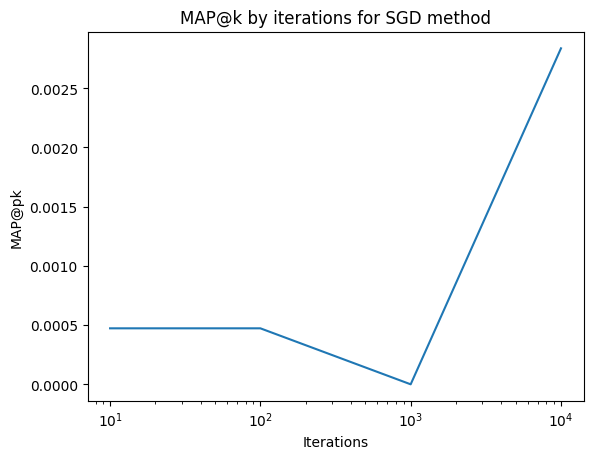

In [ ]:
mapks = []

for iters in [10, 50, 100, 1000, 10000]:
    lfm = HiddenVars(train_ratings, mode='sgd', dim=256)
    lfm.fit(iters)
    preds = lfm.get_test_recommendations(k=3)
    mapks.append(mapk(test_relevant, preds, k=3))

plt.plot([10, 50, 100, 1000, 10000], mapks)
ax = plt.gca()
ax.set_xscale('log')
ax.set_xlabel('Iterations')
ax.set_ylabel('MAP@pk')
plt.title('MAP@k by iterations for SGD method')
plt.show()

Тут в принципе есть некоторая тенденция, что чем больше итераций, тем выше качество, но зависимость не монотонная.

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

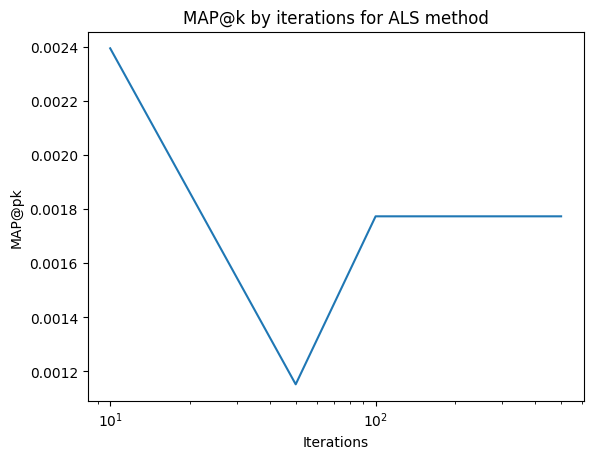

In [ ]:
mapks = []
lfm = HiddenVars(train_ratings, mode='als', dim=107)

for iters in [10, 50, 100, 500]:
    lfm.fit(iters)
    preds = lfm.get_test_recommendations(k=4)
    mapks.append(mapk(test_relevant, preds, k=4))

plt.plot([10, 50, 100, 500], mapks)
ax = plt.gca()
ax.set_xscale('log')
ax.set_xlabel('Iterations')
ax.set_ylabel('MAP@pk')
plt.title('MAP@k by iterations for ALS method')
plt.show()

Ну, а тут лучше меньшее число итераций, метод хороший.

Если у вас получилось достаточно хорошее качество, то при оптимизации параметров марицы $Q$ похожим трекам стали соответствовать похожие векторы. Поэтому мы можем для любого трека найти наиболее близкие к нему в латентном пространстве и проверить степерь обученности модели вручную.

Решила ради интереса тут качество посмотреть именно у ALS. И не зря

In [ ]:
model = HiddenVars(train_ratings, mode='als', dim=256)
model.fit(5)

  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
example_trackId = tracks_info[tracks_info.name == 'Выхода нет'].iloc[0].id

preds = model.Q @ model.Q[example_trackId]
preds = preds / np.sqrt((model.Q**2).sum(axis=1) + 1e-8)

track_idxs = preds.argsort()[::-1][:20]

In [ ]:
similar_tracks = tracks_info.loc[track_idxs][['name', 'artists']]
similar_tracks['similarity'] = preds[track_idxs] / np.linalg.norm(model.Q[example_trackId])
similar_tracks

,name,artists,similarity
5512,Выхода нет,['Сплин'],1.000000
2058,Последний герой,['КИНО'],0.723971
5517,Варвара,['Би-2'],0.696088
5521,Полковнику никто не пишет,['Би-2'],0.677587
16224,Пока горит свеча,['Машина времени'],0.671806
9433,В последнюю осень,['ДДТ'],0.651625
16192,Однажды мир прогнётся под нас,['Машина времени'],0.650861
5872,Я свободен,['Кипелов'],0.650099
17328,Я хочу быть с тобой,['Nautilus Pompilius'],0.646155
17103,Просвистела,['ДДТ'],0.644724


Ну вот, все чудесно, тут в основном рок, причем по тематике все близко.